The calculations of loss during the training of networks can use weighting to reinforce the learning of specific variables and features in data. In order to reinforce physically reasonable predictions, you can impose more strict penalties for predictions in physically invalid predictions. For example, a prediction of Power Conversion Efficiency (PCE) above the Schockley-Quassier predicted maximum PCE could increase exponentially, rather than linearly.

The classes developed below are wrappers for PyTorch tensors loss functions, which additionally modify these classes using theoretically and emprically derived boundaries for network loss calculations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm, tqdm_notebook

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_device_df.xlsx')
print (device_df.shape)
device_df.head()

# Hyper parameters
num_epochs = 100
batch_size = int(len(device_df['PCE'])*0.8*0.9) # 90% of x_train samples
learning_rate = 0.0008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
Y = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

pce_train = y_train['PCE']
pce_test = y_test['PCE']


x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))


#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))


test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

(366, 11)


In [3]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 32)
        self.h_layer2 = nn.Linear(32, 16)
        self.h_layer3 = nn.Linear(16, 8)
        
        #output layers
        self.PCE_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        out = self.h_layer3(out)
        
        #embedded data is passed to output layer
        out = self.PCE_branch(out)
        
        return out

In [4]:
def train_model(model, training_data_set, criterion, optimizer):
    train_epoch_loss = []
    train_losses = []
    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    criterion = criterion
    
    #wrapper to create progress bar & results for each epoch's training
    progress = tqdm_notebook(training_data_set, desc = 'Progress:', leave = True)
    
    for train_data, labels in progress:
        
        train_data = train_data.to(device)
        labels = labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        out = model(train_data) #gather model predictions for this loop
        
        #calculate error in the predictions
        loss = criterion(out, labels)

        #BACKPROPOGATE LIKE A MF
        loss.backward
        optimizer.step()
        
        #send results to progress bar and save loss for this batch
        progress.set_description(f'Loss: {loss.item()}:.3f')
        train_losses.append(loss.item())
        train_total+=1
        
        train_losses.append(loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    train_epoch_loss.append(sum(train_losses)/train_total)
    
    #update progress bar
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')
    
    return train_epoch_loss

In [5]:
def eval_model(model, testing_data_set, criterion, optimizer):
    #evaluate the model
    model.eval()
    
    criterion = criterion


    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
#         correct = 0
        test_losses = []
    
        test_total = 0

        for inputs, labels in testing_data_set:
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            out = model(inputs)

    
            # calculate loss per batch of testing data
            test_loss = criterion(out, labels)
            
            test_losses.append(test_loss.item())
            test_total += 1 
            

        test_epoch_loss = sum(test_losses)/test_total

        print(f"Total testing loss is: {test_epoch_loss}")
    return test_epoch_loss

In [13]:
class PCE_Loss(nn.Module):
    """
    This class contains loss functions that use a mean-squared-error loss for reasonable predictions.
    They inherit from torch.nn.Module just like the custom model. For physically unreasonable conditions,
    prediction loss is more severely calculated. What qualifies as reasonable is based on empirically
    gathered datasets and literature reported boundaries of performance in P3HT:PCBM OPV devices.
    
    For the following Power Conversion Efficiency predictions that are improbable, the loss is penalized:
    - PCE < 0%
    - PCE > 6%
    """

    def __init__(self):
        super(PCE_Loss, self).__init__()

    @staticmethod   
    def forward(predictions, labels):
#     def forward(predictions, labels):
        print (predictions.size())
        print (labels.size())
        
        result_list = torch.zeros(predictions.size(0))
        
        for x, y in zip(predictions, labels):
            el_count = 0

            if torch.le(x, torch.tensor([0])) == torch.tensor([1]):
                #Exponential MSE for x <= 0
                print(f"prediction = {x}, lower threshold violated")
                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 2)


            elif torch.ge(x, torch.tensor([6])) == torch.tensor([1]):
                #exponential MSE for x >= 6
                print(f"prediction = {x}, upper threshold violated")
                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 2)

            else:
                print(f"prediction = {x}")
                error = torch.add(x, torch.neg(y))
                element_result = torch.pow(error, 2)
                
            result_list[el_count] = element_result
            el_count+=1

            result = result_list.mean()

            return result

In [14]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
model = NN1(in_dims = 2, out_dims = 4).to(device)

#define the loss function and the optimizer
criterion = PCE_Loss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [15]:
#empty list to hold loss per epoch
train_epoch_losses = []


test_epoch_losses = []


for epoch in range(num_epochs):
    
    train_epoch_loss, = train_model(model = model,
                                    training_data_set = training_data_set,
                                    criterion = criterion,
                                    optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    
    
    test_epoch_loss = eval_model(model = model,
                                 testing_data_set = testing_data_set,
                                 criterion = criterion,
                                 optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)

torch.Size([263, 1])
torch.Size([263])
prediction = tensor([-6.0054], grad_fn=<SelectBackward>), lower threshold violated
torch.Size([29, 1])
torch.Size([29])
prediction = tensor([-5.1114], grad_fn=<SelectBackward>), lower threshold violated

Epoch #1	Train Loss: 112.665


ValueError: too many values to unpack (expected 1)

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

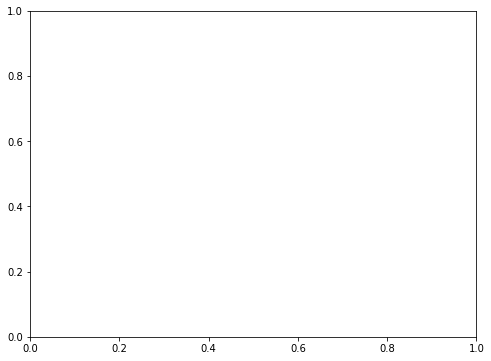

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()